# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

У нас есть данные с количеством этажей общим, на каком этаже квартира, место ее нахождения, общая и жилая площади, площадь кухни, удаленность от аэропорта, парка и пруда, цена, дата размещения и снятия объявления.
Потребуется привести данные к виду, возможному для анализа.
После предобработки данных, я выявлю корреляции между данными параметрами и сроком продажи квартиры.

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd# импортируйте библиотеку pandas
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 50) 

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')# Изучите общую информацию о полученном датафрейме

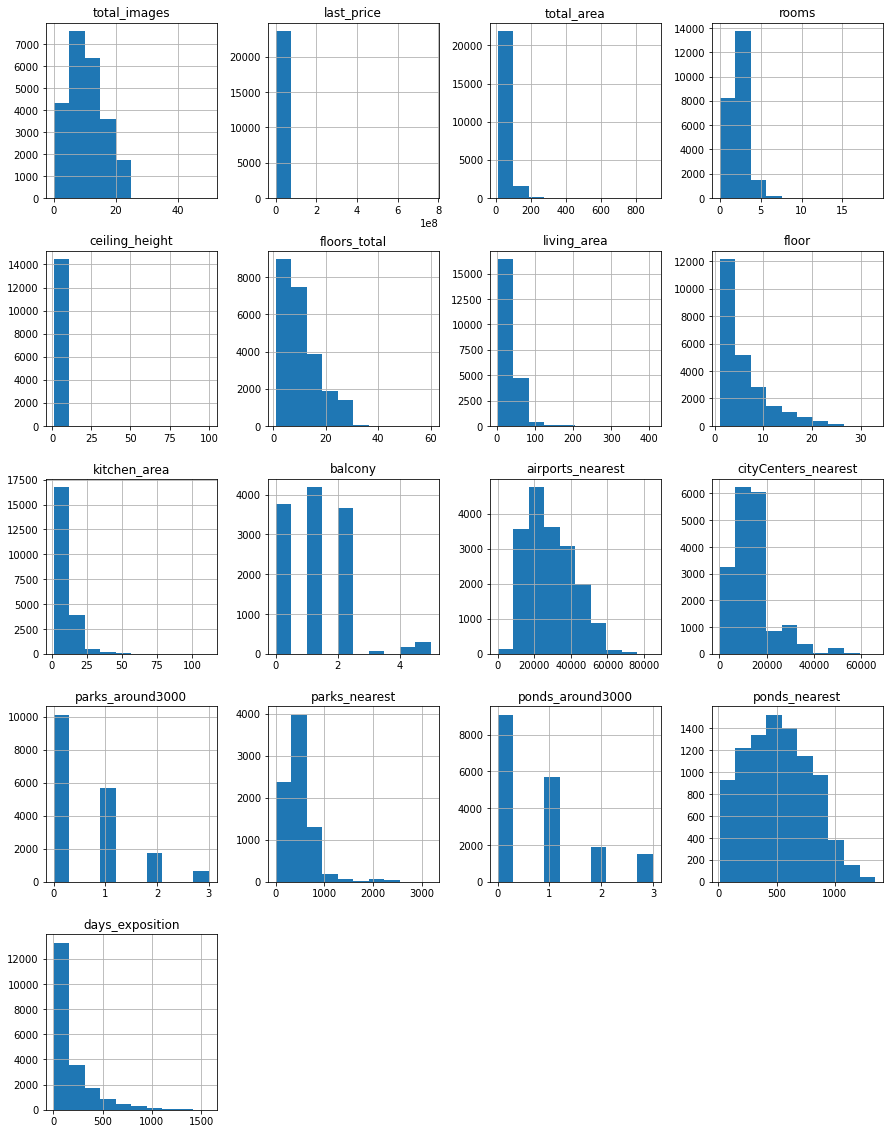

In [3]:
data.hist(figsize=(15, 20)) #Постройте общую гистограмму для всех числовых столбцов таблицы.
None

### Предобработка данных

In [4]:
print(data.info)#Определедяем, в каких столбцах есть пропуски.

<bound method DataFrame.info of        total_images  last_price  total_area first_day_exposition  rooms  \
0                20  13000000.0      108.00  2019-03-07T00:00:00      3   
1                 7   3350000.0       40.40  2018-12-04T00:00:00      1   
2                10   5196000.0       56.00  2015-08-20T00:00:00      2   
3                 0  64900000.0      159.00  2015-07-24T00:00:00      3   
4                 2  10000000.0      100.00  2018-06-19T00:00:00      2   
...             ...         ...         ...                  ...    ...   
23694             9   9700000.0      133.81  2017-03-21T00:00:00      3   
23695            14   3100000.0       59.00  2018-01-15T00:00:00      3   
23696            18   2500000.0       56.70  2018-02-11T00:00:00      2   
23697            13  11475000.0       76.75  2017-03-28T00:00:00      2   
23698             4   1350000.0       32.30  2017-07-21T00:00:00      1   

       ceiling_height  floors_total  living_area  floor is_apartmen

In [5]:
missing_values = data.isnull().sum()# считаем количество пропусков по каждому столбцу
missing_percentage = (missing_values / len(data)) * 100
missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Количество', 'Процент'])
print(missing_data)

                      Количество    Процент
total_images                   0   0.000000
last_price                     0   0.000000
total_area                     0   0.000000
first_day_exposition           0   0.000000
rooms                          0   0.000000
ceiling_height              9195  38.799105
floors_total                  86   0.362885
living_area                 1903   8.029875
floor                          0   0.000000
is_apartment               20924  88.290645
studio                         0   0.000000
open_plan                      0   0.000000
kitchen_area                2278   9.612220
balcony                    11519  48.605426
locality_name                 49   0.206760
airports_nearest            5542  23.384953
cityCenters_nearest         5519  23.287902
parks_around3000            5518  23.283683
parks_nearest              15620  65.909954
ponds_around3000            5518  23.283683
ponds_nearest              14589  61.559559
days_exposition             3181

Больше всех пропусков:по высоте потолков, более 38%. Данные пропуски заполним медианной. Признак аппартамент является не обязательным, так как аппартаменты-это коммерческая недвижимость, поэтому можем данный признак пропустить. Пропуски по балкону я заполню исходя из существующих данных. Приближенность к паркам, прудам и аэропортам- это картографические пропуски, их я трогать не буду. Пропуски по жилой площади, менее 10%, но я могу их заполнить также медианой.

In [6]:
median_ceiling_height = data['ceiling_height'].median()# заполнение и проверка пропусков по столбцу ceiling_height медианным значением
data['ceiling_height'] = data['ceiling_height'].fillna(median_ceiling_height)
print(data['ceiling_height'].isnull().sum()) 

0


In [7]:
def fill_living_area(row):
    if pd.isnull(row['living_area']):
        median_value = data[data['rooms'] == row['rooms']]['living_area'].median()
        return median_value
    else:
        return row['living_area']
data['living_area'] = data.apply(fill_living_area, axis=1) # заполнение пропусков в столбце living_area

In [8]:
data['balcony'] = data['balcony'].fillna(0) # заполнение не актуальных пропусков
data['is_apartment'] = data['is_apartment'].fillna(0)
data['parks_nearest'] = data['parks_nearest'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_nearest'] = data['ponds_nearest'].fillna(0)

In [9]:
def fill_kitchen_area(row): # заполнение пропусков kitchen_area
    if pd.isnull(row['kitchen_area']):
        median_value = data[data['total_area'] == row['total_area']]['kitchen_area'].median()
        return median_value
    else:
        return row['kitchen_area']
data['kitchen_area'] = data.apply(fill_kitchen_area, axis=1)

In [10]:
data['days_exposition'] = pd.to_numeric(data['days_exposition'], errors='ignore')
data = data.dropna(subset=['days_exposition'])# Удаляем строки, содержащие неопределенные значения (NaN)
data['days_exposition'] = data['days_exposition'].astype(float, errors='ignore')

In [11]:
print(data.head(20)) # проверка пропусков

    total_images  last_price  total_area first_day_exposition  rooms  \
1              7   3350000.0       40.40  2018-12-04T00:00:00      1   
2             10   5196000.0       56.00  2015-08-20T00:00:00      2   
3              0  64900000.0      159.00  2015-07-24T00:00:00      3   
4              2  10000000.0      100.00  2018-06-19T00:00:00      2   
5             10   2890000.0       30.40  2018-09-10T00:00:00      1   
6              6   3700000.0       37.30  2017-11-02T00:00:00      1   
8             20   2900000.0       33.16  2018-05-23T00:00:00      1   
9             18   5400000.0       61.00  2017-02-26T00:00:00      3   
10             5   5050000.0       39.60  2017-11-16T00:00:00      1   
11             9   3300000.0       44.00  2018-08-27T00:00:00      2   
12            10   3890000.0       54.00  2016-06-30T00:00:00      2   
13            20   3550000.0       42.80  2017-07-01T00:00:00      2   
14             1   4400000.0       36.00  2016-06-23T00:00:00   

В процессе предобработки файла были выявленны случайные и не случайные пропуски. К полностью случайным пропускам я бы отнесла пропуски по балконам, аппартаментам, есть ли рялом пруд и парк. Я их заполнила нулями, так как при отсутствия значения по другим полям понятно, что данное значение должно быть 0.
Не случайными пропусками являются пропуски по площади кухни, жилая площадь в квадратных метрах (м²) и высота потолков. я их заполнила медианным значением в зависимости от площади квартиры и города проживания.
Также есть пропуски в полях расстояние до центра города (м) и расстояние до ближайшего аэропорта в метрах (м). Для заполнения данных пропусков требуются картографичекие данные.
Пропуски в сколько дней было размещено объявление (от публикации до снятия) оставила, так как для заполнения требуется дополнительная информация о дате размещения и снятие объявления.

In [12]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])# изменение типа данных в столбце даты,для комфортного восприятия, так время не требуется


In [13]:
data['days_exposition'] = data['days_exposition'].astype('Int64', errors='ignore')

In [14]:
# Удаляем неявные дубликаты в столбце locality_name
data['locality_name'] = data['locality_name'].str.lower() # Приводим все значения к нижнему регистру
data['locality_name'] = data['locality_name'].str.strip() # Удаляем лишние пробелы в начале и конце строки
data['locality_name'] = data['locality_name'].str.replace('ё', 'е') # Заменяем букву "ё" на "е"

In [15]:
unique_localities = data['locality_name'].unique()# смотрим уникальные значение названий населенных пунктов
print(unique_localities)

['поселок шушары' 'санкт-петербург' 'городской поселок янино-1'
 'поселок парголово' 'поселок мурино' 'ломоносов' 'сертолово' 'петергоф'
 'пушкин' 'деревня кудрово' 'коммунар' 'колпино'
 'поселок городского типа красный бор' 'гатчина' 'деревня федоровское'
 'выборг' 'кронштадт' 'кировск' 'деревня новое девяткино'
 'поселок металлострой' 'поселок городского типа сиверский'
 'поселок молодцово' 'поселок городского типа кузьмоловский' 'павловск'
 'деревня пикколово' 'всеволожск' 'кингисепп' 'сестрорецк'
 'деревня куттузи' 'поселок городского типа ефимовский' 'поселок плодовое'
 'деревня заклинье' 'поселок торковичи' 'красное село' 'поселок понтонный'
 'сясьстрой' 'поселок новый свет' 'приозерск' 'сланцы' 'село путилово'
 'ивангород' 'шлиссельбург' 'никольское' 'зеленогорск' 'сосновый бор'
 'деревня оржицы' 'деревня кальтино' 'поселок романовка' 'поселок бугры'
 'поселок городского типа рощино' 'луга' 'волосово' 'отрадное'
 'село павлово' 'поселок оредеж' 'село копорье' 'кудрово' 'тихвин'


In [16]:
data['locality_name'] = data['locality_name'].replace('поселок Рябово', 'поселок городского типа Рябово')# заменяем дублирующие названия

In [17]:
data['locality_name'] = data['locality_name'].replace('поселок мурино', 'мурино')

In [18]:
data['ceiling_height'].describe() # проверяем аномалии по столбцу потолков

count    20518.000000
mean         2.715667
std          0.970099
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

из данных мы видим, что есть потолки со значением 100м, считаю эти данные выбросом

In [19]:
data = data[data['ceiling_height'] != 100] # удаляем выбросы по потолкам

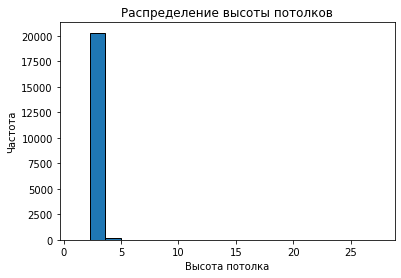

Выбросы по столбцу ceiling_height:


In [20]:
# Создание гистограммы для столбца ceiling_height
plt.hist(data['ceiling_height'], bins=20, edgecolor='black')
plt.xlabel('Высота потолка')
plt.ylabel('Частота')
plt.title('Распределение высоты потолков')
plt.show()

# Определение минимального и максимального значений потолка
min_height = data['ceiling_height'].min()
max_height = data['ceiling_height'].max()

# Определение нижнего и верхнего квартилей
lower_quartile = data['ceiling_height'].quantile(0.25)
upper_quartile = data['ceiling_height'].quantile(0.75)

# Вычисление интерквартильного размаха
iqr = upper_quartile - lower_quartile

# Определение нижней и верхней границ выбросов
lower_bound = lower_quartile - 1.5 * iqr
upper_bound = upper_quartile + 1.5 * iqr

# Фильтрация выбросов
outliers = data[(data['ceiling_height'] < lower_bound) | (data['ceiling_height'] > upper_bound)]

print("Выбросы по столбцу ceiling_height:")

In [21]:
low_percentele = 0.01
hihg_percentele = 0.99

last_price_low = data['last_price'].quantile(low_percentele)
last_price_high = data['last_price'].quantile(hihg_percentele)

print(f'Нижняя граница last_price {last_price_low}')
print(f'Верхняя граница last_price {last_price_high}')

print(
    'Процент отброшенных значений = ',
    round(
        100 - len(data.query('@last_price_low <= last_price <= @last_price_high'))
        / len(data['last_price']) * 100,
        2
    ),
    '%'
)

Нижняя граница last_price 1050000.0
Верхняя граница last_price 34000000.0
Процент отброшенных значений =  1.96 %


In [22]:
data['floor'].describe()# проверяем аномалии по столбцу этажей

count    20517.000000
mean         5.987181
std          4.944031
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

чаще всего встречаются квартиры на средних этажах.

In [23]:
data['floors_total'].describe()

count    20440.000000
mean        10.861057
std          6.652412
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Чаще всего присутствуют квартиры в средних домах, 9-ти этажках, но есть высотки.

In [24]:
data['kitchen_area'].describe()

count    20323.000000
mean        10.316553
std          5.546362
min          2.000000
25%          7.000000
50%          9.000000
75%         11.600000
max        112.000000
Name: kitchen_area, dtype: float64

Кухни с площадью от 2 до 10кв.м. -самое частое явление. Удивляет кухня с площадью 112кв.м

In [25]:
data['living_area'].describe()

count    20517.000000
mean        33.436504
std         20.967806
min          2.000000
25%         18.000000
50%         30.000000
75%         42.000000
max        409.700000
Name: living_area, dtype: float64

Жилая площадь 2 кв. м. думаю выброс. Среднее значение по жилой площади 33кв.м. 

In [26]:
data['rooms'].describe()

count    20517.000000
mean         2.024614
std          1.054809
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

0 комнат-это выброс, чаще всего одно и двух-комнатные квартиры. Радует наличие 19-ти комнатной квартиры.

### Посчитайте и добавьте в таблицу новые столбцы

In [27]:
data['price_per_sqm'] = data['last_price'] / data['living_area'] # считаем цена одного квадратного метра

In [28]:
# Преобразуем столбец firstdayexp в формат даты
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

# Добавляем столбец 'день недели'
data['weekday'] = data['first_day_exposition'].dt.weekday

# Добавляем столбец 'месяц'
data['month'] = data['first_day_exposition'].dt.month

# Добавляем столбец 'год'
data['year'] = data['first_day_exposition'].dt.year


In [29]:
# Создаем функцию, которая будет определять тип этажа
def determine_floor_type(row):
    if row['floor'] == row['floors_total']:
        return 'последний'
    elif row['floor'] == 1:
        return 'первый'
    else:
        return 'другой'

# Применяем функцию к каждой строке датафрейма и сохраняем результат в новом столбце
data['тип этажа'] = data.apply(determine_floor_type, axis=1)

In [30]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round()#добавляем столбец расстояние до центра города в километрах

### Проведите исследовательский анализ данных

(array([1.6628e+04, 3.1680e+03, 3.4300e+02, 1.2600e+02, 3.5000e+01,
        1.1000e+01, 6.0000e+00, 0.0000e+00, 4.0000e+00, 2.0000e+00]),
 array([  2.,  13.,  24.,  35.,  46.,  57.,  68.,  79.,  90., 101., 112.]),
 <BarContainer object of 10 artists>)

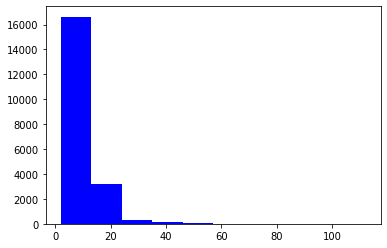

In [31]:
plt.hist(data['kitchen_area'],color='blue')# гистограмма по площади кухни

(array([  107., 11318.,  6583.,  1390.,   445.,   186.,   110.,    65.,
           48.,    32.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 10 artists>)

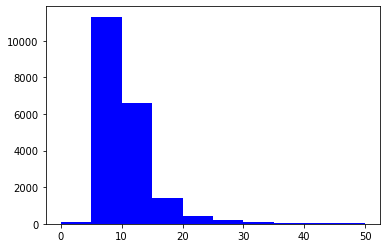

In [32]:
plt.hist(data['kitchen_area'], color='blue', range=(0, 50))

кухни до 10 кв. м преобладают среди общего количества, от 10-22 кв.м. -значений меньше в несколько раз, кухни с большой площадью есть в очень малых количествах.

(array([4.000e+00, 1.800e+01, 6.180e+02, 5.622e+03, 1.248e+03, 2.462e+03,
        3.315e+03, 1.495e+03, 1.694e+03, 1.624e+03]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 10 artists>)

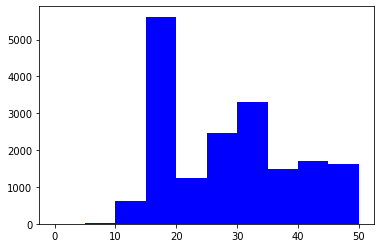

In [33]:
plt.hist(data['living_area'],color='blue', range=(0, 50))# гистограмма по  жилой площади 

Большая часть квартир с жилой площадью до 20кв.м, от 20 до 300кв.м.- квартиры встречаются реже в несколько раз, квартир площадью более 100кв.м.- очень мало

(array([1.915e+04, 1.160e+03, 1.380e+02, 4.200e+01, 1.400e+01, 1.000e+01,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 12. , 100.8, 189.6, 278.4, 367.2, 456. , 544.8, 633.6, 722.4,
        811.2, 900. ]),
 <BarContainer object of 10 artists>)

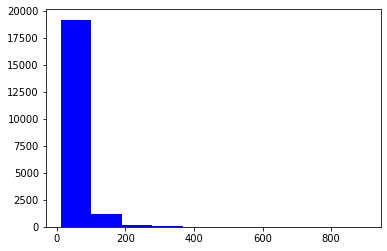

In [34]:
plt.hist(data['total_area'], color='blue')# гистограмма по общей площади квартиры

В основном квартиры с общей площадью до 100кв.м, от 200-400 кв.м. очень редкий случай.

(array([2.0462e+04, 4.2000e+01, 5.0000e+00, 4.0000e+00, 1.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.21900000e+04, 7.63109710e+07, 1.52609752e+08, 2.28908533e+08,
        3.05207314e+08, 3.81506095e+08, 4.57804876e+08, 5.34103657e+08,
        6.10402438e+08, 6.86701219e+08, 7.63000000e+08]),
 <BarContainer object of 10 artists>)

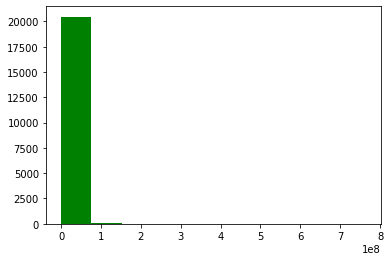

In [35]:
plt.hist(data['last_price'], color='green') # гистограмма по цене

Цена по основным квартирам бриблизительно одинаковая (считаю связанным с самым популярным выбором до 100кв.м)

(array([7.4550e+03, 1.1732e+04, 1.1930e+03, 1.1300e+02, 1.5000e+01,
        3.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

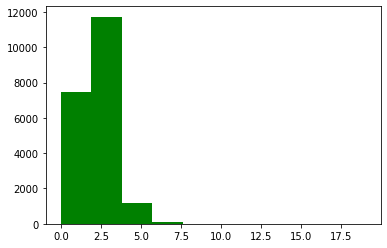

In [36]:
plt.hist(data['rooms'], color='green')# гистограмма по количеству комнат

В основном преобладают двух и трех комнатные квартиры, далее по популярности- однокомнатные, малое количество 4 и 5 комнатные. 

(array([2.0342e+04, 1.5300e+02, 4.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.4000e+01]),
 array([ 1.  ,  3.65,  6.3 ,  8.95, 11.6 , 14.25, 16.9 , 19.55, 22.2 ,
        24.85, 27.5 ]),
 <BarContainer object of 10 artists>)

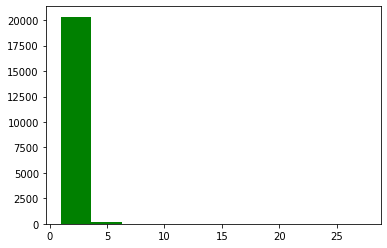

In [37]:
plt.hist(data['ceiling_height'], color='green')# гистограмма по высоте потолков

Полотки в основном до 4м. Более высокие потолки встречаются редко

(array([1.0372e+04, 6.3260e+03, 2.1970e+03, 1.0770e+03, 4.6400e+02,
        7.8000e+01, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 10 artists>)

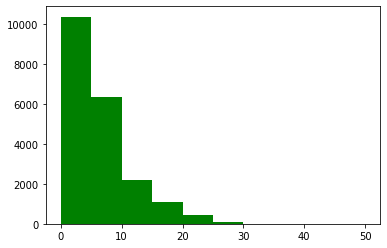

In [38]:
plt.hist(data['floor'], color='green', range=(0, 50))# гистограмма по этажам

Большая часть квартир на нижних этажах, чем выше этаж- тем меньше значений

(array([ 2450.,     0.,     0.,     0.,     0., 15230.,     0.,     0.,
            0.,  2837.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

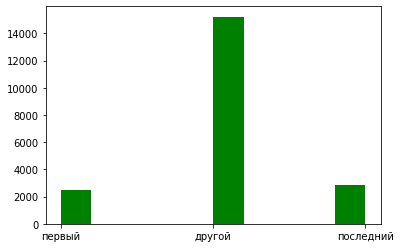

In [39]:
plt.hist(data['тип этажа'], color='green')# гистограмма по типу этажа

Самое большое количество средних этажей, мало кто предпочитает первый этаж либо последний.

(array([1.858e+03, 9.786e+03, 3.090e+03, 3.007e+03, 1.398e+03, 1.276e+03,
        2.000e+00, 2.100e+01, 0.000e+00, 0.000e+00]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 10 artists>)

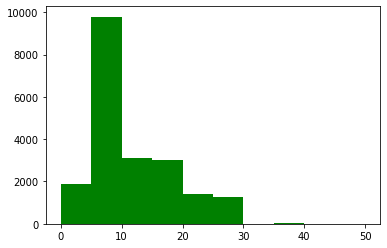

In [40]:
plt.hist(data['floors_total'], color='green', range=(0, 50))# гистограмма по общему количеству этажей

Дома в основном  до 9-ти этажа, это самые популярные постройки на сегодняшний день (либо 5-ти этажки, оставшийся из старого фонда), высокоэтажных домов мало. небоскребов-единицы.

(array([2705., 5522., 5324.,  753.,  966.,  328.,   33.,  201.,   24.,
           8.]),
 array([  208.,  6784., 13360., 19936., 26512., 33088., 39664., 46240.,
        52816., 59392., 65968.]),
 <BarContainer object of 10 artists>)

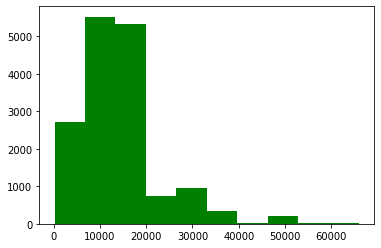

In [41]:
plt.hist(data['cityCenters_nearest'], color='green')# гистограмма по близости у центру

В основном дома среднеудаленны от центра города, думаю связанно с инфроструктурными зданиями, которых обычно в центрах города больше для привлечения туристов.

(array([ 126., 3111., 4119., 3127., 2680., 1749.,  771.,   94.,   59.,
           6.]),
 array([    0. ,  8486.9, 16973.8, 25460.7, 33947.6, 42434.5, 50921.4,
        59408.3, 67895.2, 76382.1, 84869. ]),
 <BarContainer object of 10 artists>)

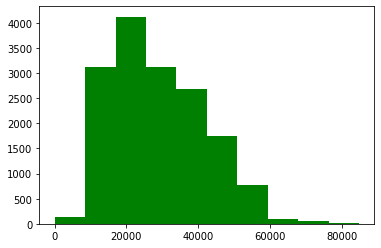

In [42]:
plt.hist(data['airports_nearest'], color='green')# гистограмма по близости к аэропорту

Также как и с центром: основное количество среднеудаленно от аэропорта, но считаю это уже связанно с непосредствееным планом города. На практике в городах редко делают жилые дома близко к аэропорту в целях безопастности и комфортного проживания (рядом с аэропортом очень шумно жить)

(array([1.5642e+04, 3.3750e+03, 1.1330e+03, 1.6600e+02, 6.6000e+01,
        2.7000e+01, 5.0000e+01, 4.6000e+01, 5.0000e+00, 7.0000e+00]),
 array([   0.,  319.,  638.,  957., 1276., 1595., 1914., 2233., 2552.,
        2871., 3190.]),
 <BarContainer object of 10 artists>)

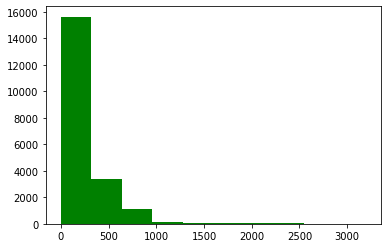

In [43]:
plt.hist(data['parks_nearest'], color='green')# гистограмма по близости к парку

Большая часть домов расположена рядом с парком, так как это повышает комфорт проживания и стоимость квартиры (обеспечение свежего воздуха, красивый вид, места для отдыха и спорта)

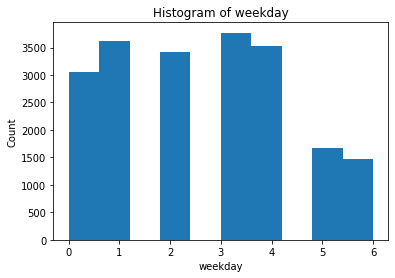

In [44]:
data['weekday'].plot.hist() # гистограмма по дням недели
plt.xlabel('weekday')
plt.ylabel('Count')
plt.title('Histogram of weekday')
plt.show()

Чаще всего квартиры приобретаются в понедельк и среду, реже во вторник и четверг. В пятницу и субботу самое малое количество, подозреваю потому что ближе к выходным люди уже планируют отдых либо более глобальные дела.

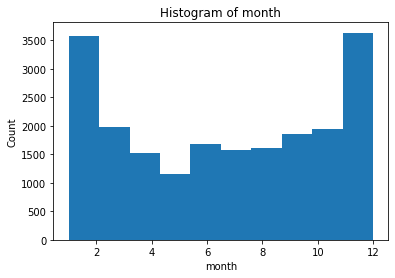

In [45]:
data['month'].plot.hist()# гистограмма по месяцам продаж
plt.xlabel('month')
plt.ylabel('Count')
plt.title('Histogram of month')
plt.show()

Чаще всего люди покупают квартиры либо в начале года либо в конце, думаю это связанно с ежегодным повышением цен на недвижимость, так люди пытаются купить до сезонного повышения и встретить новый год в новом жилье.

(array([13266.,  3565.,  1746.,   871.,   455.,   275.,   182.,    92.,
           49.,    16.]),
 array([1.0000e+00, 1.5890e+02, 3.1680e+02, 4.7470e+02, 6.3260e+02,
        7.9050e+02, 9.4840e+02, 1.1063e+03, 1.2642e+03, 1.4221e+03,
        1.5800e+03]),
 <BarContainer object of 10 artists>)

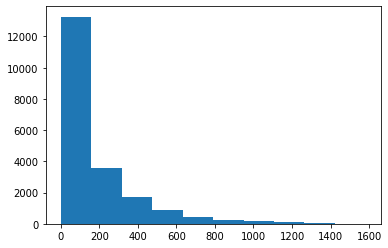

In [46]:
plt.hist(data['days_exposition'])# гистограмма по дням продажи

In [47]:
data['days_exposition'].mean()# среднее значение по дням продажи

180.89652483306526

In [48]:
data['days_exposition'].median()# медиана по дням продажи

95.0

Среднее время продажи квартиры 180 дней. Интересно, что при этом медианой является значение в 2 раза меньше среднего. Получается, что большая часть квартир продаются за 95 дней и меньше - более 200 дней, что хорошо подтверждает гистограмма. При этом есть квартиры, которые продаются от 800 дней до 1400, что является больше редкостью.

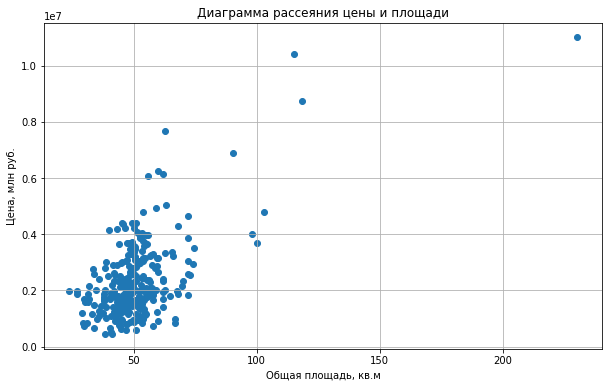

In [49]:
# Группировка данных по столбцу locality_name и вычисление средней цены и площади в каждой группе
grouped_data = data.groupby('locality_name').agg({'last_price': 'mean', 'total_area': 'mean'})

# Создание и настройка графика
plt.figure(figsize=(10, 6))
plt.scatter(grouped_data['total_area'], grouped_data['last_price'])
plt.title('Диаграмма рассеяния цены и площади')
plt.xlabel('Общая площадь, кв.м')
plt.ylabel('Цена, млн руб.')
plt.grid(True)
plt.alpha=0.3

# Вывод графика на экран
plt.show()

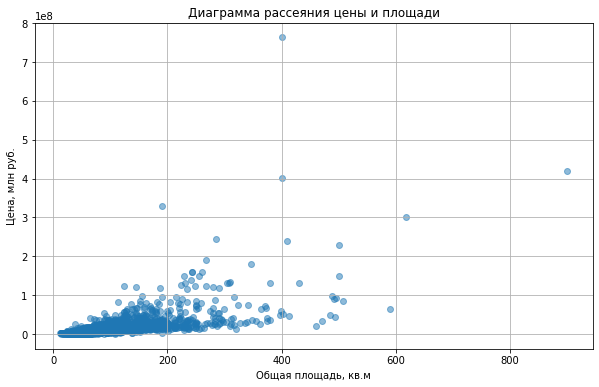

In [50]:
# Создание и настройка графика
plt.figure(figsize=(10, 6))
plt.scatter(data['total_area'],data['last_price'],alpha=0.5)
plt.title('Диаграмма рассеяния цены и площади')
plt.xlabel('Общая площадь, кв.м')
plt.ylabel('Цена, млн руб.')
plt.grid(True)

# Вывод графика на экран
plt.show()

Чем больше площадь,тем больше-цена. Самое популярное сочетание: примерная площадь- около 60кв.м. и цена до 4млн. руб.

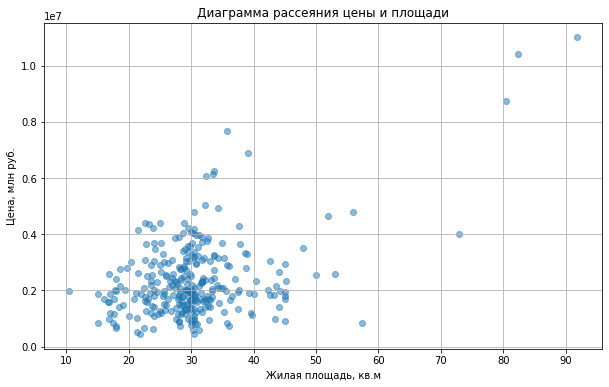

In [51]:
# Группировка данных по столбцу locality_name и вычисление средней цены и площади в каждой группе
grouped_data = data.groupby('locality_name').agg({'last_price': 'mean', 'living_area': 'mean'})

# Создание и настройка графика
plt.figure(figsize=(10, 6))
plt.scatter(grouped_data['living_area'], grouped_data['last_price'], alpha=0.5)
plt.title('Диаграмма рассеяния цены и площади')
plt.xlabel('Жилая площадь, кв.м')
plt.ylabel('Цена, млн руб.')
plt.grid(True)

# Вывод графика на экран
plt.show()

Согласно выбору покупателей приваллирует жилая площадь 30кв.м и цена 2 млн. руб.

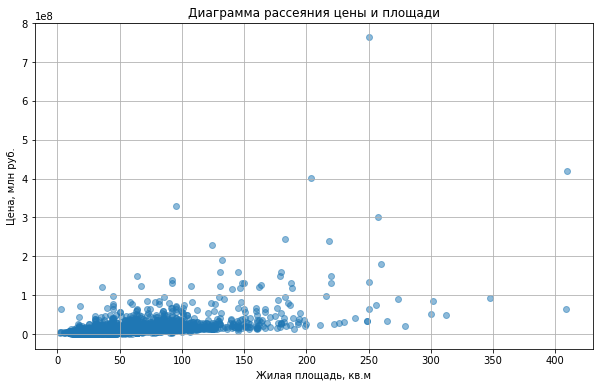

In [52]:
# Создание и настройка графика
plt.figure(figsize=(10, 6))
plt.scatter(data['living_area'],data['last_price'], alpha=0.5)
plt.title('Диаграмма рассеяния цены и площади')
plt.xlabel('Жилая площадь, кв.м')
plt.ylabel('Цена, млн руб.')
plt.grid(True)

# Вывод графика на экран
plt.show()

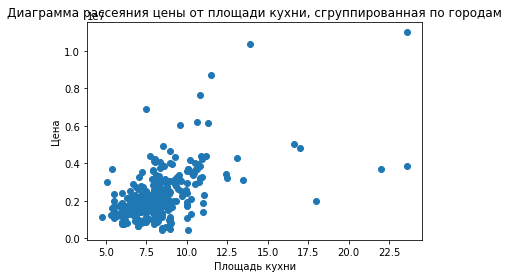

In [53]:
# Группировка данных по городам и вычисление средней цены и площади кухни
grouped_data = data.groupby('locality_name').agg({'last_price': 'mean', 'kitchen_area': 'mean'}).reset_index()

# Построение диаграммы рассеяния
plt.scatter(grouped_data['kitchen_area'], grouped_data['last_price'])

# Настройка осей и заголовка графика
plt.xlabel('Площадь кухни')
plt.ylabel('Цена')
plt.title('Диаграмма рассеяния цены от площади кухни, сгруппированная по городам')

# Отображение графика
plt.show()

В основном площадь кухни от 5 до 10 кв.м. При этом мы видим, что общая площадь кухни не существенно влияет на общую стоимость. Больше данный показатель зависит от жилой площади.

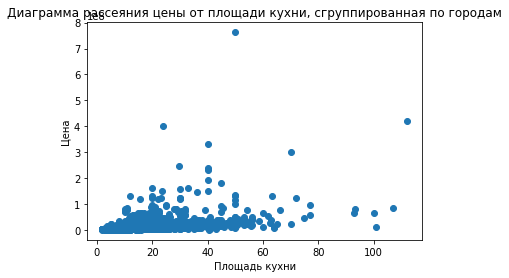

In [54]:
# Построение диаграммы рассеяния
plt.scatter(data['kitchen_area'], data['last_price'])

# Настройка осей и заголовка графика
plt.xlabel('Площадь кухни')
plt.ylabel('Цена')
plt.title('Диаграмма рассеяния цены от площади кухни, сгруппированная по городам')


# Отображение графика
plt.show()

<AxesSubplot:xlabel='last_price', ylabel='total_area'>

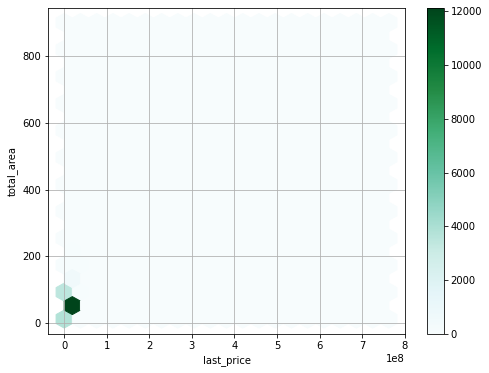

In [55]:
data.plot(x='last_price', y='total_area', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) #считаем коэффициент корреляции Пирсона

In [56]:
print(data[['last_price', 'total_area']].corr())

            last_price  total_area
last_price    1.000000    0.643191
total_area    0.643191    1.000000


Корреляция сильная

In [57]:
# Создаем сводную таблицу
pivot_table = pd.pivot_table(data, values='last_price', index='rooms', aggfunc='count')

# Выводим сводную таблицу
print(pivot_table)

       last_price
rooms            
0             183
1            7272
2            6913
3            4819
4             941
5             252
6              76
7              37
8              11
9               4
10              2
11              1
12              1
14              2
15              1
16              1
19              1


Одно и двух- комнатные квартиры самые популярные

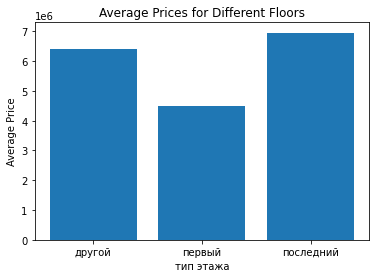

In [58]:
# Рассчитываем средние цены для разных типов этажей
average_prices = data.groupby('тип этажа')['last_price'].mean()

# Построение столбчатой диаграммы
plt.bar(average_prices.index, average_prices.values)
plt.xlabel('тип этажа')
plt.ylabel('Average Price')
plt.title('Average Prices for Different Floors')
plt.show()

Первый этаж - самая низкая цена, на последнем этаже самые высокие цены.

In [59]:
# Создание сводной таблицы с группировкой по дню недели и расчетом средней цены
weekday_avg_price = data.groupby('weekday')['last_price'].mean()

# Создание сводной таблицы с группировкой по месяцу и расчетом средней цены
month_avg_price = data.groupby('month')['last_price'].mean()

# Создание сводной таблицы с группировкой по году и расчетом средней цены
year_avg_price = data.groupby('year')['last_price'].mean()
print(weekday_avg_price)
print(month_avg_price)
print(year_avg_price)

weekday
0    6.173478e+06
1    6.096600e+06
2    6.407972e+06
3    6.378834e+06
4    6.073881e+06
5    6.883008e+06
6    6.013331e+06
Name: last_price, dtype: float64
month
1     6.257470e+06
2     6.166220e+06
3     5.829664e+06
4     6.652354e+06
5     6.506009e+06
6     6.148108e+06
7     6.434915e+06
8     6.012247e+06
9     6.678086e+06
10    5.867248e+06
11    6.190242e+06
12    6.768317e+06
Name: last_price, dtype: float64
year
2014    1.135684e+07
2015    8.199937e+06
2016    6.713275e+06
2017    6.442632e+06
2018    5.609559e+06
2019    5.868534e+06
Name: last_price, dtype: float64


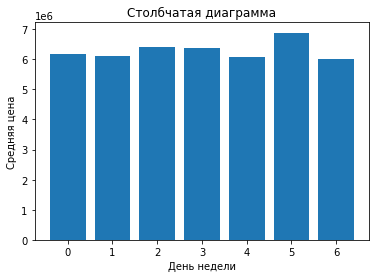

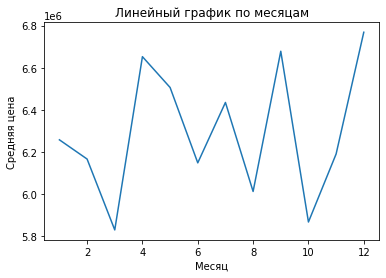

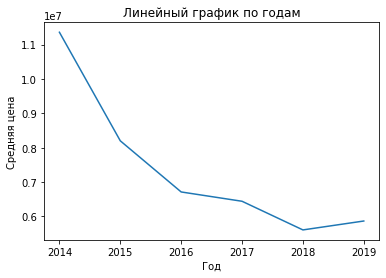

In [60]:
# Столбчатая диаграмма
avg_price_weekday = data.groupby('weekday')['last_price'].mean()
fig, ax = plt.subplots()
ax.bar(avg_price_weekday.index, avg_price_weekday.values)
ax.set_xlabel('День недели')
ax.set_ylabel('Средняя цена')
ax.set_title('Столбчатая диаграмма')
plt.show()

# Линейный график по месяцам
avg_price_month = data.groupby('month')['last_price'].mean()
fig, ax = plt.subplots()
ax.plot(avg_price_month.index, avg_price_month.values)
ax.set_xlabel('Месяц')
ax.set_ylabel('Средняя цена')
ax.set_title('Линейный график по месяцам')
plt.show()

# Линейный график по годам
avg_price_year = data.groupby('year')['last_price'].mean()
fig, ax = plt.subplots()
ax.plot(avg_price_year.index, avg_price_year.values)
ax.set_xlabel('Год')
ax.set_ylabel('Средняя цена')
ax.set_title('Линейный график по годам')
plt.show()

Исходя из данных сводных таблиц по дате обьявления и цены мы видим:1. цена по дням недели увеливалась в среду и в пятницу (скорее всего это самые популярные дни для обновления данных) 2. Цена на квартиры увеличивалась в апреле, сентябре и в декабре больше чем в другие месяцы. считаю это связанным с сезонным повышением стоимости недвижимости. 3. В 2015 году цена на недвижимость сделала резкий скачок вверх и далее колебается в примерно одном диапазоне. Только в 2018г. было резкое снижение. Считаю его связанным с политическими изменениями в стране.

In [61]:
top_localities = data['locality_name'].value_counts().head(10).index.tolist()#выбираем 10 населенных пунктов с наибольшим числом объявлений.
mean_price_per_sqm = data[data['locality_name'].isin(top_localities)].groupby('locality_name')['last_price'].mean() / data[data['locality_name'].isin(top_localities)].groupby('locality_name')['total_area'].mean()#считаем среднюю цену одного квадратного метра для каждого из этих населенных пунктов, используя столбцы 'total_area' и 'last_price'
highest_price_per_sqm = mean_price_per_sqm.idxmax()#выделяем населенные пункты с самой высокой и низкой стоимостью квадратного метра.
lowest_price_per_sqm = mean_price_per_sqm.idxmin()
print("Населенный пункт с самой высокой стоимостью квадратного метра:", highest_price_per_sqm)
print("Населенный пункт с самой низкой стоимостью квадратного метра:", lowest_price_per_sqm)

Населенный пункт с самой высокой стоимостью квадратного метра: санкт-петербург
Населенный пункт с самой низкой стоимостью квадратного метра: выборг


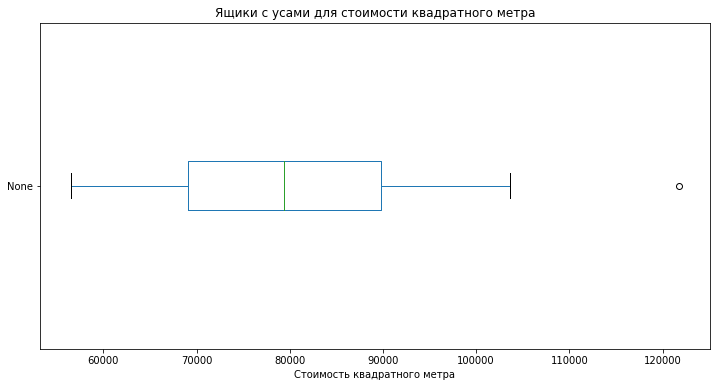

In [62]:
#Фильтруем данные по выбранным населенным пунктам
filtered_data = data[data['locality_name'].isin(top_localities)]

#Группируем данные по населенным пунктам и считаем среднюю стоимость квадратного метра
mean_price_per_sqm = filtered_data.groupby('locality_name')['last_price'].mean() / filtered_data.groupby('locality_name')['total_area'].mean()

#Строим ящики с усами
plt.figure(figsize=(12, 6)) 
mean_price_per_sqm.plot(kind='box', vert=False) 
plt.xlabel('Стоимость квадратного метра') 
plt.title('Ящики с усами для стоимости квадратного метра') 
plt.show()

(0.0, 500000.0)

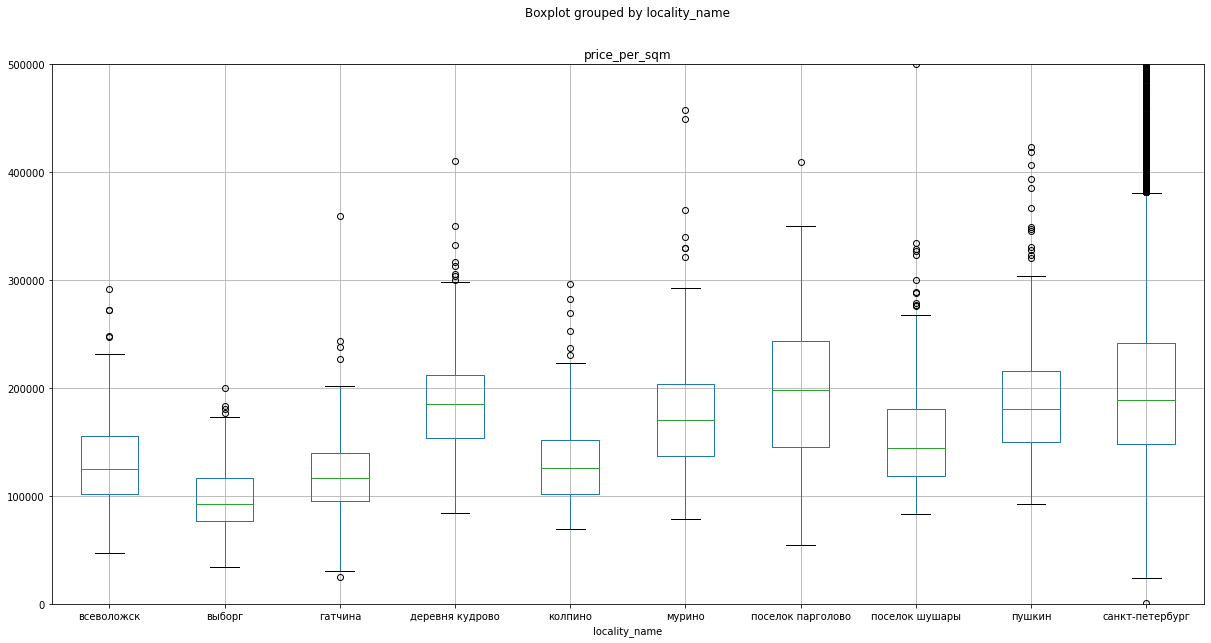

In [63]:

ax = (data
    .query('locality_name in @top_localities')
    .boxplot('price_per_sqm', by='locality_name', figsize=(20, 10))
)
ax.set_ylim(0, 500000)

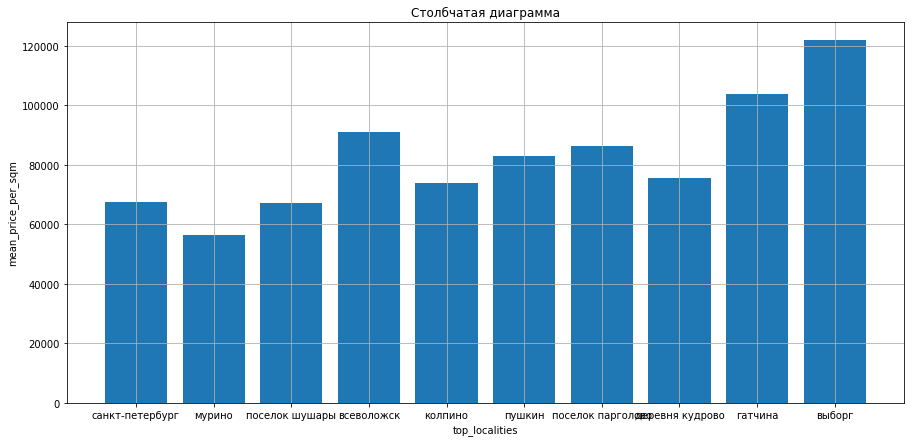

In [64]:
top_localities = data['locality_name'].value_counts().head(10).index.tolist()#выбираем 10 населенных пунктов с наибольшим числом объявлений.
mean_price_per_sqm = data[data['locality_name'].isin(top_localities)].groupby('locality_name')['last_price'].mean() / data[data['locality_name'].isin(top_localities)].groupby('locality_name')['total_area'].mean()#считаем среднюю цену одного квадратного метра для каждого из этих населенных пунктов, используя столбцы 'total_area' и 'last_price'

x = top_localities
y = mean_price_per_sqm
# Создание и настройка графика
plt.figure(figsize=(15, 7))
plt.bar(x, y)
plt.title('Столбчатая диаграмма')
plt.xlabel('top_localities')
plt.ylabel('mean_price_per_sqm')
plt.grid(True)

# Вывод графика на экран
plt.show()

Стоимость кв. метра от 70 до 90 тыс.р.

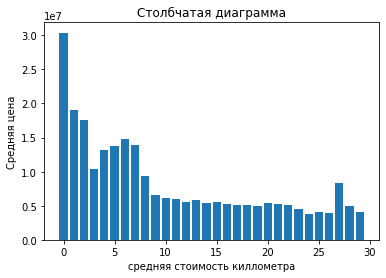

In [65]:
spb_apartments = data[data['locality_name'] == 'санкт-петербург']#  вычислияем среднюю цену каждого километра по Санкт-Петербургу
average_price_per_km = spb_apartments.groupby('cityCenters_nearest_km')['last_price'].mean()
average_price_per_km = average_price_per_km.round(2)
fig, ax = plt.subplots()
ax.bar(average_price_per_km.index, average_price_per_km.values)
ax.set_xlabel('средняя стоимость киллометра')
ax.set_ylabel('Средняя цена')
ax.set_title('Столбчатая диаграмма')
plt.show()

Чем ближе к центру- тем выше цена. За пределами центра-цена не сильно варьируется. Считаю что это связанно с инфроструктурой и "престижностью" географического положения.

### Общий вывод

Общий вывод: Данные в файле были обработанны: заполнены пропуски, исключены выбросы информации, картографические данные оставила неизменными. Потребовалось также изменить тип данных по дате на дататайм.

Цена квартиры зависит от географического положения, удаленности к центру, количества комнат и общей жилой площади. Первые этажи считаются самыми дешевыми, последние этажи-самые дорогие. Площадь кухни зависит только от самой планировки, но хочу отметить, что преобладают квартиры с малой кухней. Самыми дорогими квартирами являются квартиры в Санкт-Петербурге, самыми экономичными- в Выборге. Чаще предпочитают квартиры с парковыми зонами. Среднее значение по всем параметрам: квартира  одно или двух комнатная, с общей жилой площадью до 50кв.м на первом либо средних этажах, среднеудаленная от центра города, недалеко от парка  в 2019г. была по стоимости от 4 млн.р.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод